In [4]:
from cmdstanpy import CmdStanModel, from_csv

import numpy as np
import scipy.stats as stats
import arviz as az

import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Remarks
To run this notebook you need minimum of 16GBs of RAM. Also models are fitted and sampled using separate script, because it takes hours to fit them. In this notebook they're read from csvs, which are available here: https://drive.google.com/file/d/1K6SIB9vhR5yCagJBRwbji16pcLUo4bnw/view?usp=sharing

You need this data to properly run this notebook, so download and unpack them beforehand in the same folder as this notebook!

If you would like to fit models yourself, then you should use models_fitting.py script. Warning: it deletes previous fits, so create backup if you don't want to lose that data!

Notebook is designed to run cell by cell, if done otherwise will probably crash.

# DATA

In [ ]:
# load data
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 20]

# TEMP: only for testing plots and functions
train_df = pd.DataFrame(df.iloc[:, :])

# normalized distance
train_df["Normalized distances"] = (train_df["Road distances [km]"] - train_df["Road distances [km]"].mean()) / train_df["Road distances [km]"].std()

# normalized meal preparation time
train_df["Normalized mealprep"] = (train_df["Meal_preparation_time"] - train_df["Meal_preparation_time"].mean()) / train_df["Meal_preparation_time"].std()

# map categorical traffic density to numbers
road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])

#------------------------------------------------------- parameters exclusive for model 2 --------------------------------------------------

# delivery person rating
train_df["Normalized person_rating"] = (train_df["Delivery_person_Ratings"] - train_df["Delivery_person_Ratings"].mean()) / train_df["Delivery_person_Ratings"].std()

# number of deliveries
train_df["multiple_deliveries"] = train_df["multiple_deliveries"]+1


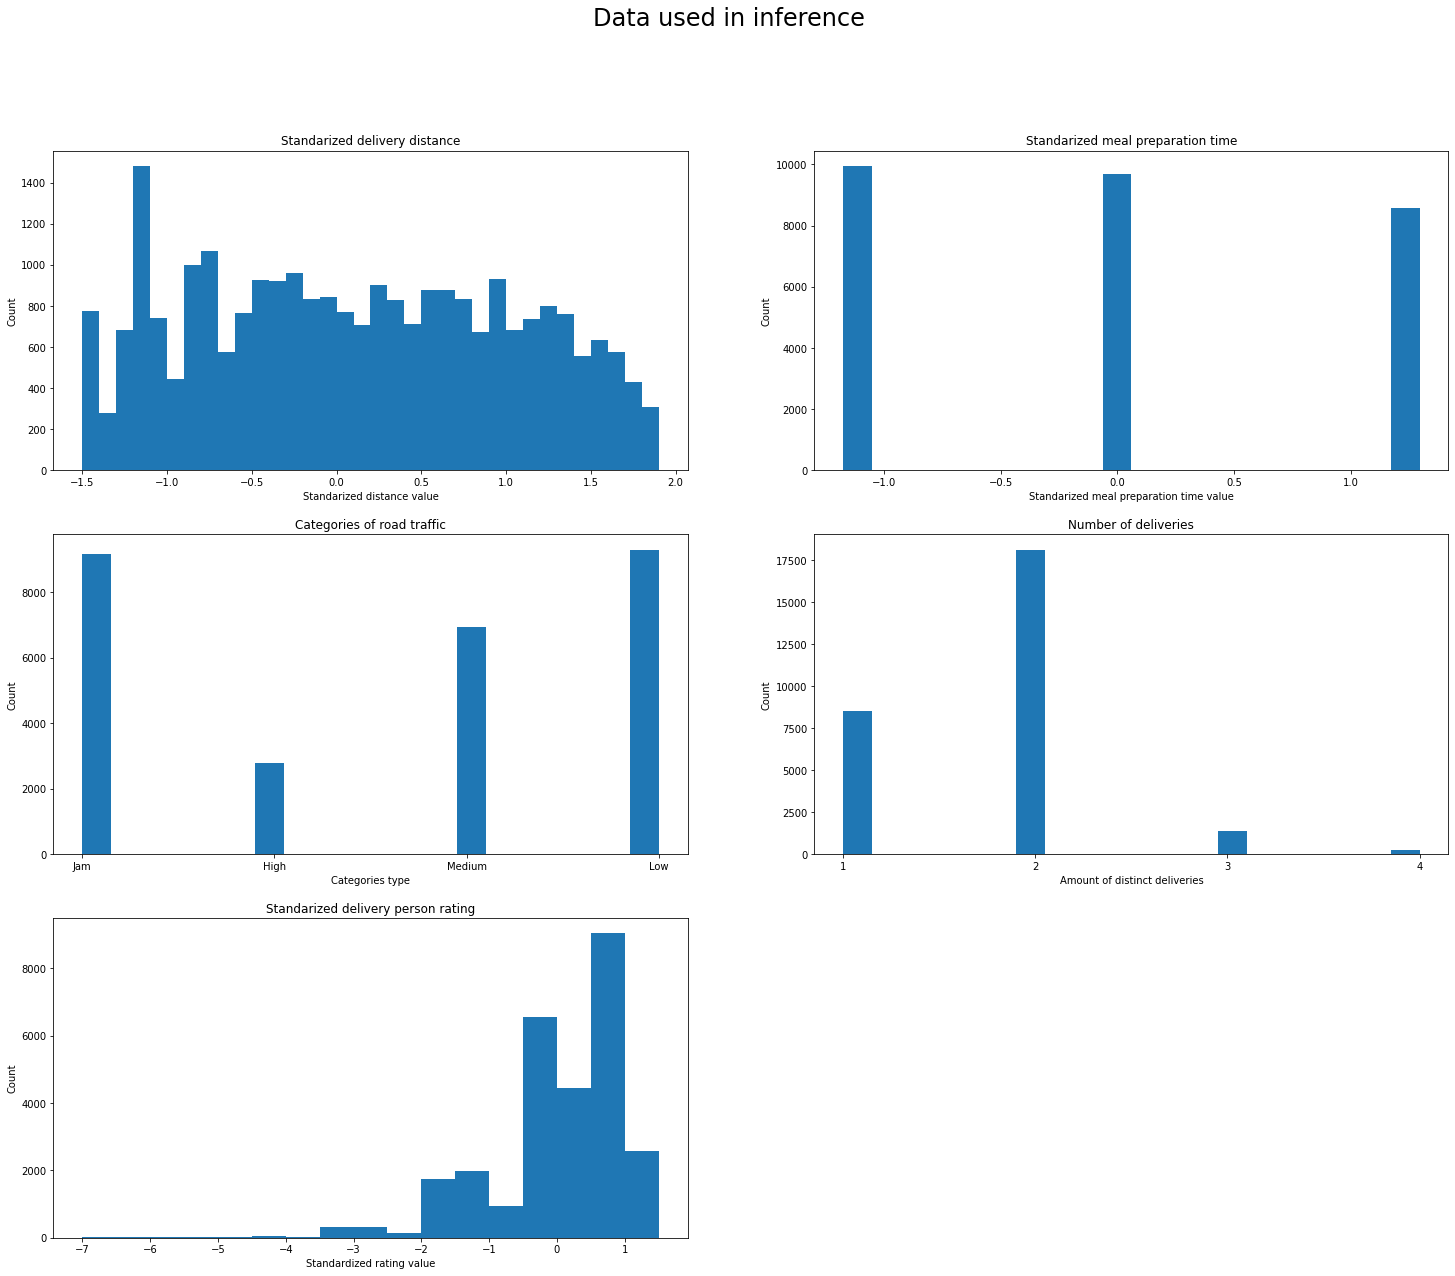

In [38]:
# plot data

fig, ax = plt.subplots(3,2, figsize=(25,20))
fig.suptitle("Data used in inference", fontsize=24)

ax[0,0].hist(train_df["Normalized distances"], bins=np.arange(-1.5,2.0,0.1))
ax[0,0].set_title("Standarized delivery distance")
ax[0,0].set_xlabel("Standarized distance value")
ax[0,0].set_ylabel("Count")

ax[0,1].hist(train_df["Normalized mealprep"], bins=20)
ax[0,1].set_title("Standarized meal preparation time")
ax[0,1].set_xlabel("Standarized meal preparation time value")
ax[0,1].set_ylabel("Count")

ax[1,0].hist(train_df["Road_traffic_density"], bins=20)
ax[1,0].set_title("Categories of road traffic")
ax[1,0].set_xlabel("Categories type")
ax[1,0].set_ylabel("Count")
ax[1,0].set_xticks([1,2,3,4])
ax[1,0].set_xticklabels(["Jam","High","Medium","Low"])


ax[1,1].hist(train_df["multiple_deliveries"], bins=20)
ax[1,1].set_title("Number of deliveries")
ax[1,1].set_xlabel("Amount of distinct deliveries")
ax[1,1].set_xticks([1,2,3,4])
ax[1,1].set_ylabel("Count")

ax[2,0].hist(train_df["Normalized person_rating"], bins=np.arange(-7,2,0.5))
ax[2,0].set_title("Standarized delivery person rating")
ax[2,0].set_xlabel("Standardized rating value")
ax[2,0].set_ylabel("Count")
ax[2,0].set_xticks(np.arange(-7,2,1))

ax[2,1].remove()

fig.savefig('plots/data.png', facecolor='w')

# PPC AND FIT - MODEL 1

In [9]:
# read ppc for model 1
with open('model1_ppc.stan') as file:
    print(file.read())


data{
    int N; // no of samples
    array[N] real distance;   // distances
    array[N] real meal_preparation_time;
    array[N] int traffic_level;
}

generated quantities {
   real distance_coeff = normal_rng(0, 0.3);
   real meal_prep_coeff = normal_rng(0, 0.3);
   real mean = normal_rng(3, 0.1);

   array[4] real traffic_level_coeff;
   traffic_level_coeff[1] = normal_rng(0, 0.3);
   traffic_level_coeff[2] = normal_rng(0, 0.3);
   traffic_level_coeff[3] = normal_rng(0, 0.3);
   traffic_level_coeff[4] = normal_rng(0, 0.3);

   array[N] real mu;
   real sigma = exponential_rng(0.5);
   array[N] real delivery_times;

   for (i in 1:N){
      mu[i] = exp(distance_coeff*distance[i] + traffic_level_coeff[traffic_level[i]]+meal_prep_coeff*meal_preparation_time[i]+mean);
      delivery_times[i] = inv_gamma_rng(pow(mu[i], 2) / pow(sigma, 2) + 2, pow(mu[i],3) / pow(sigma, 2) + mu[i]);
   }
}


In [3]:
# remove previously sampled ppc for model 1
files = glob.glob('models_output/model1/ppc/*')
for f in files:
    os.remove(f)

model1_ppc=CmdStanModel(stan_file='model1_ppc.stan')

model1_ppc_sim=model1_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613,
                     output_dir='models_output/model1/ppc/')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |███████▌  | 00:29 Iteration: 700 / 1000 [ 70%]  (Sampling)

KeyboardInterrupt: 

chain 1 |█████████▏| 00:37 Iteration: 900 / 1000 [ 90%]  (Sampling)

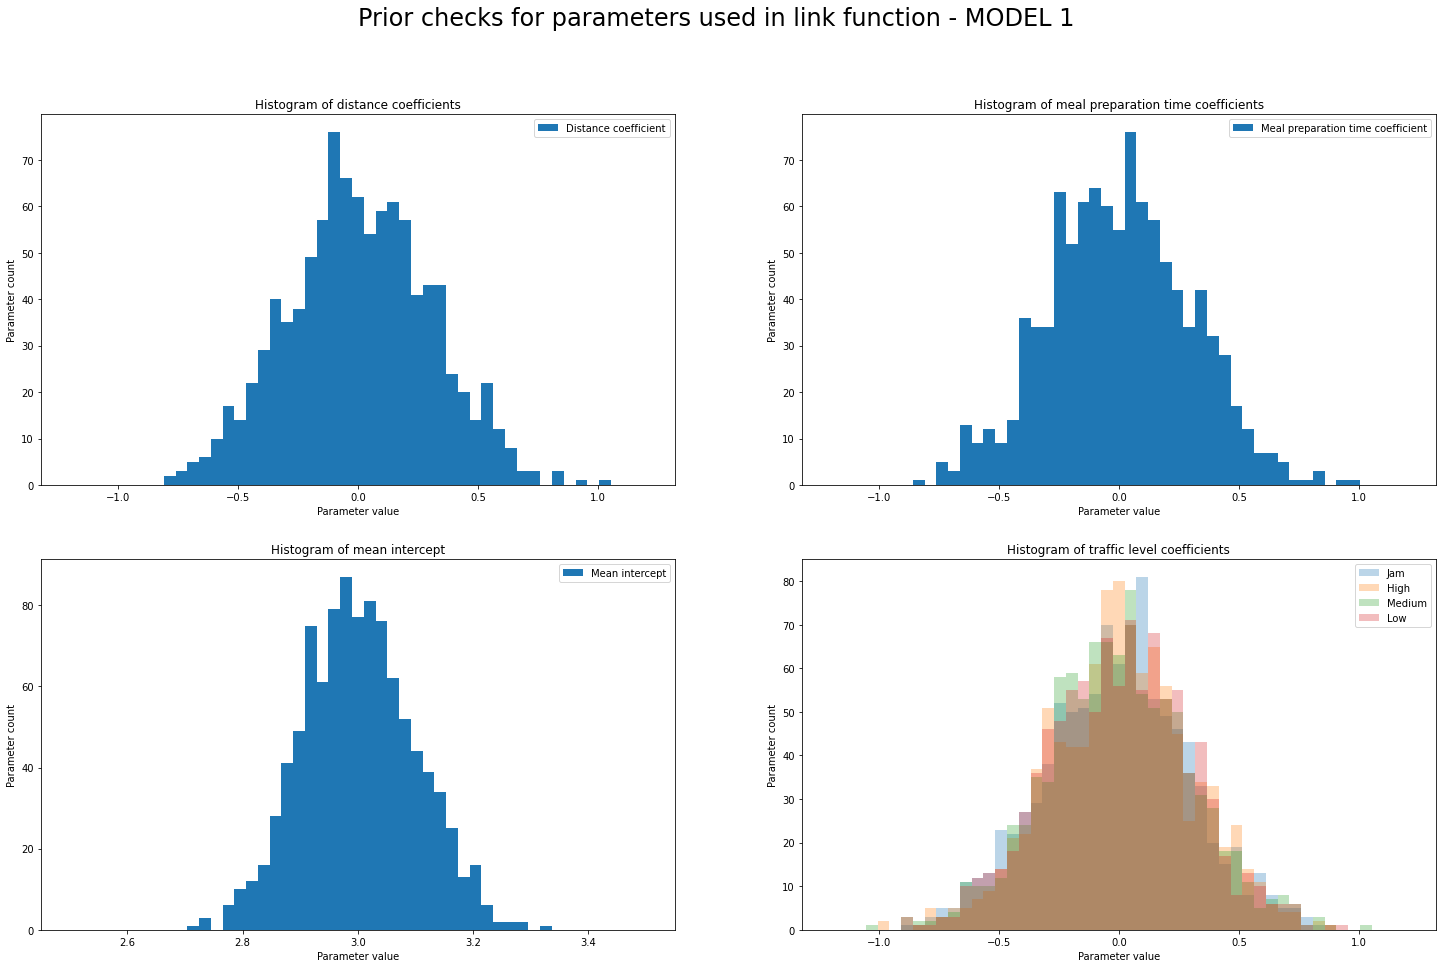

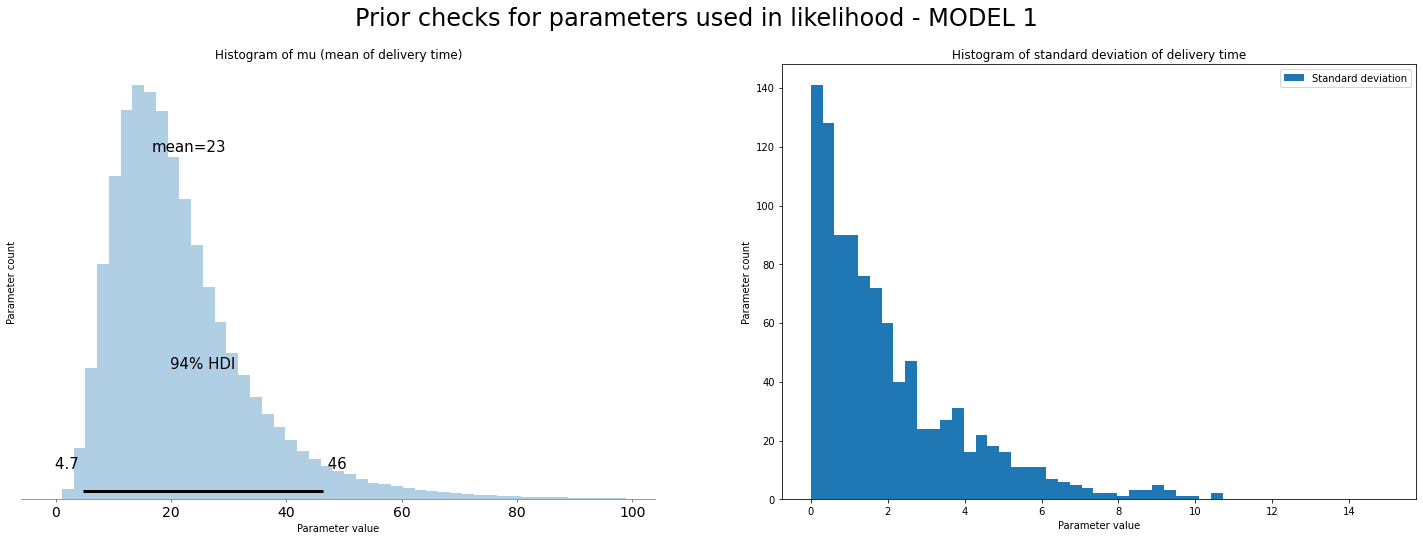

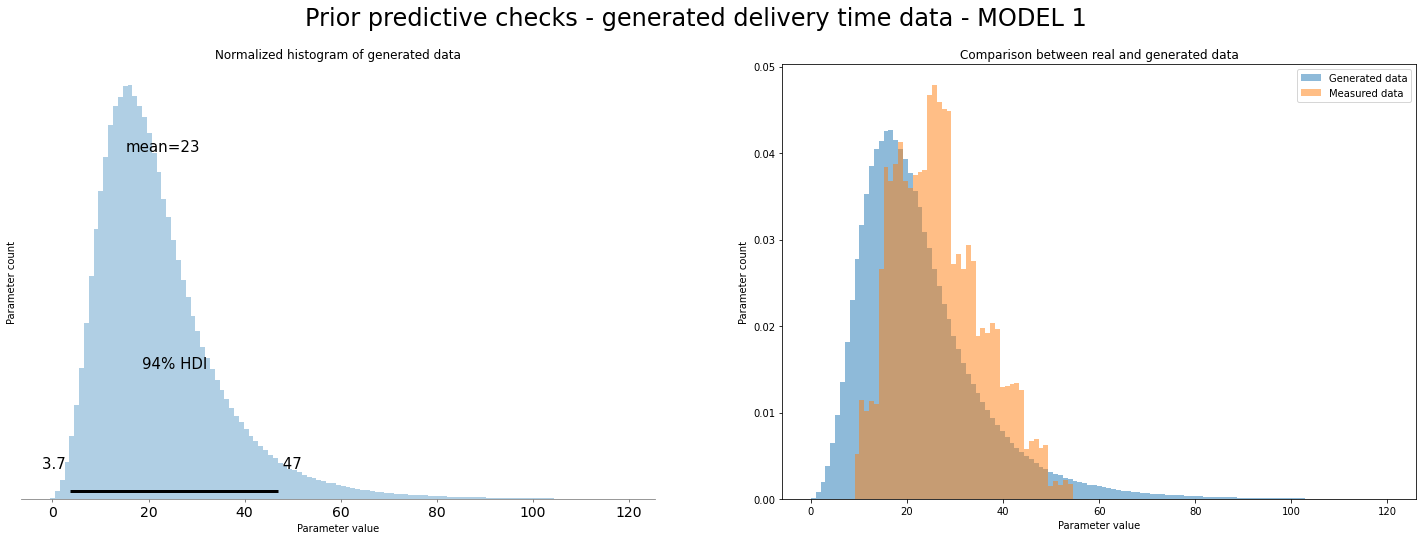

In [ ]:
# plot preparation
fig, ax = plt.subplots(2,2, figsize=(25,15))
fig.suptitle("Prior checks for parameters used in link function - MODEL 1", fontsize=24)

# get distance coeff
model1_ppc_distance_coeff = model1_ppc_sim.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model1_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model1_ppc_meal_prep_coeff = model1_ppc_sim.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model1_ppc_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model1_ppc_mean = model1_ppc_sim.stan_variable('mean')

# plot mean
ax[1,0].hist(model1_ppc_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model1_ppc_traffic_coeff = model1_ppc_sim.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model1_ppc_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model1_ppc_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")
plt.show()

# save plot
fig.savefig('plots/model1/link_params_ppc.png', facecolor='w')

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = model1_ppc_sim.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(0,100,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model1_ppc_sigma = model1_ppc_sim.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation", bins=np.linspace(0,15,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

# save plot
fig1.savefig('plots/model1/model_params_ppc.png', facecolor='w')

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_ppc_measurements = model1_ppc_sim.stan_variable('delivery_times').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 120, 120)

az.plot_posterior(model1_ppc_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# plot measurements
ax2[1].hist(model1_ppc_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# save plot
fig2.savefig('plots/model1/generated_data_ppc.png', facecolor='w')


In [1]:
# read ppc for model 1
with open('model1_fit.stan') as file:
    print(file.read())

data{
    int N;                          // Number of samples
    vector[N] distance;             // Distances
    vector[N] meal_preparation_time; // Meal preparation times
    vector[N] delivery_times;       // Delivery times
    array[N] int traffic_level;           // Traffic levels
}

parameters{
    real distance_coeff;
    real mean;
    vector[4] traffic_level_coeff;
    real meal_prep_coeff;
    real<lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    for(i in 1:N){
        mu[i] = exp(distance_coeff * distance[i] + traffic_level_coeff[traffic_level[i]] + meal_prep_coeff * meal_preparation_time[i]+mean);
    }

}

model{
    mean ~ normal(3, 0.1);
    distance_coeff ~ normal(0,0.5);
    meal_prep_coeff ~ normal(0,0.5);
    sigma ~ exponential(0.5);
    delivery_times ~ inv_gamma(pow(mu, 2) / pow(sigma, 2) + 2, pow(mu,3) / pow(sigma, 2) + mu);
    traffic_level_coeff[1] ~ normal(0, 0.5);
    traffic_level_coeff[2] ~ normal(0, 0.5);
    traffic_level_coeff[3] ~ no

In [4]:
# load model from previously sampled csvs
model1_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model1/fit')

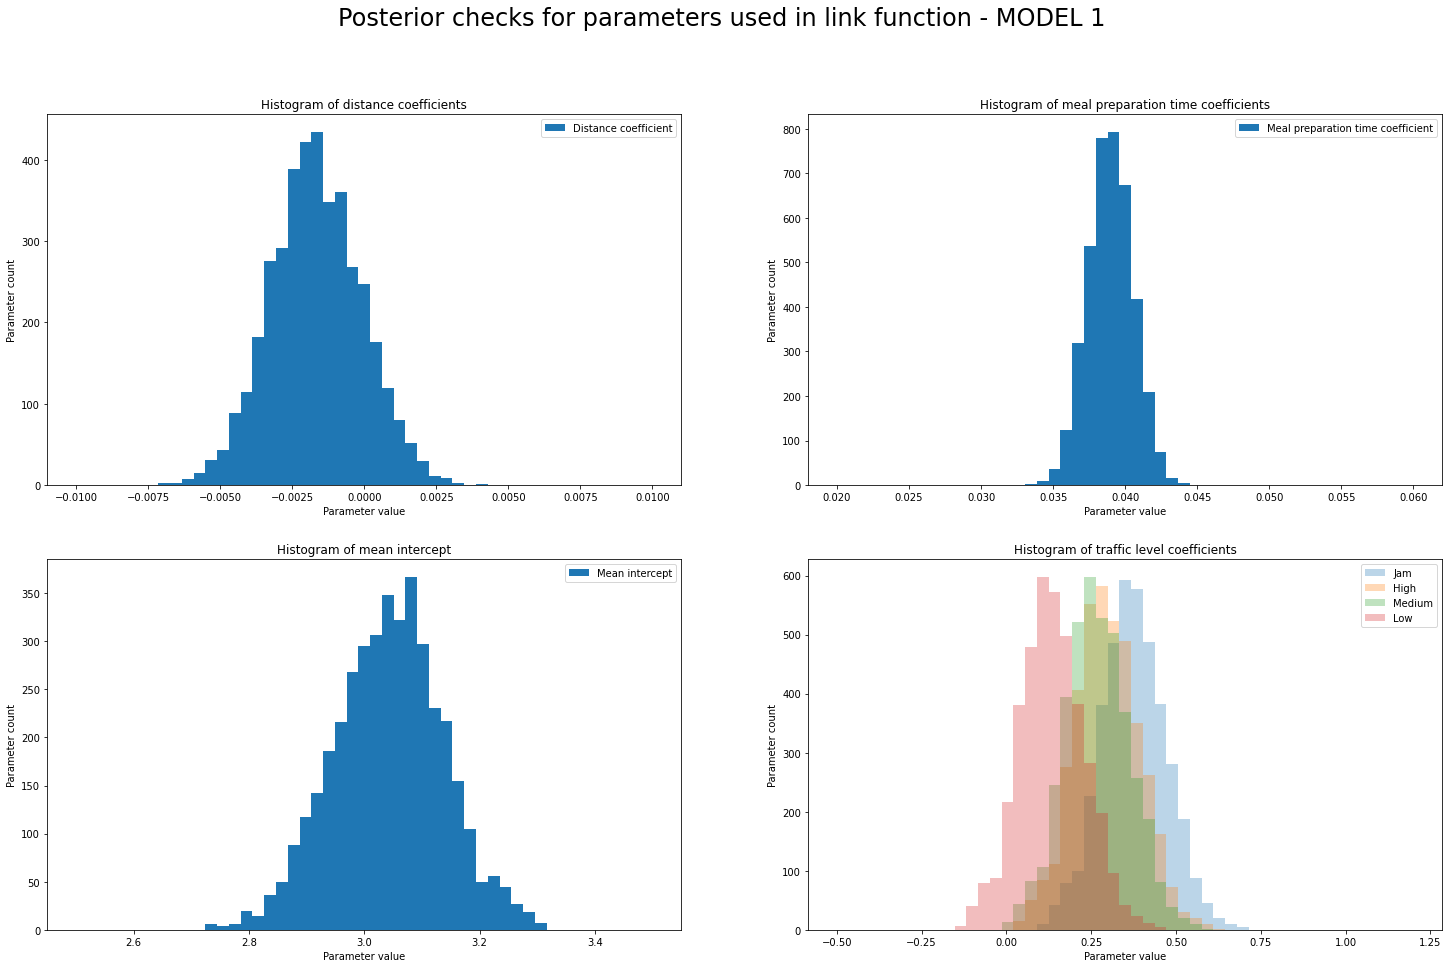

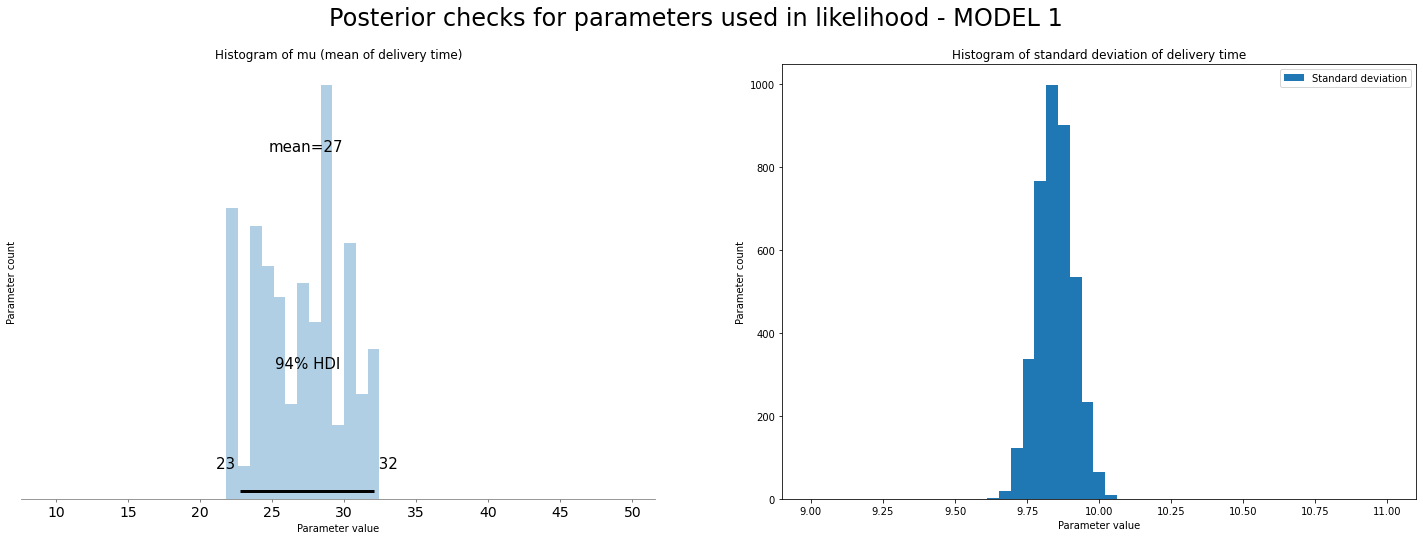

chain 1 |█████████▏| 06:34 Iteration: 1000 / 1000 [100%]  (Sampling)


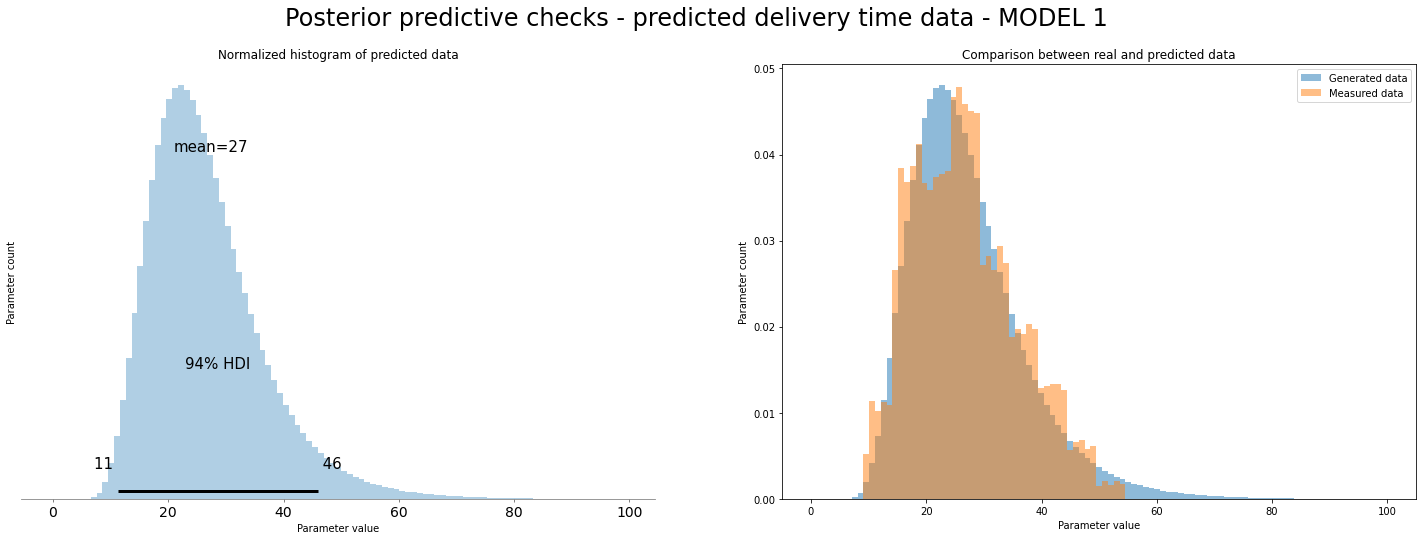

In [6]:
# plot preparation
fig, ax = plt.subplots(2,2, figsize=(25,15))
fig.suptitle("Posterior checks for parameters used in link function - MODEL 1", fontsize=24)

# get distance coeff
model1_fit_distance_coeff = model1_sample.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model1_fit_distance_coeff,label="Distance coefficient", bins=np.linspace(-0.01,0.01,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model1_fit_meal_prep_coeff = model1_sample.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model1_fit_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(0.02,0.06,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model1_fit_mean = model1_sample.stan_variable('mean')

# plot mean
ax[1,0].hist(model1_fit_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model1_fit_traffic_coeff = model1_sample.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model1_fit_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].hist(model1_fit_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-0.5,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")
plt.show()

# save plot
fig.savefig('plots/model1/link_params_fit.png', facecolor='w')

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Posterior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_fit_mu = model1_sample.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_fit_mu, kind='hist', ax=ax1[0], bins=np.linspace(10,50,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model1_fit_sigma = model1_sample.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_fit_sigma,label="Standard deviation", bins=np.linspace(9,11,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

# save plot
fig1.savefig('plots/model1/model_params_fit.png', facecolor='w')

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Posterior predictive checks - predicted delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_fit_measurements = model1_sample.stan_variable('delivery_time').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 100, 100)

az.plot_posterior(model1_fit_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of predicted data")

# plot measurements
ax2[1].hist(model1_fit_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and predicted data")
plt.show()

# save plot
fig2.savefig('plots/model1/sampled_data_fit.png', facecolor='w')

# PPC AND FIT - MODEL 2

In [1]:
# read ppc for model 2
with open('model2_ppc.stan') as file:
    print(file.read())

data{
    int N; // no of samples
    array[N] real distance;   // distances
    array[N] real meal_preparation_time;
    array[N] int traffic_level;
    array[N] real delivery_person_rating;
    array[N] int number_of_deliveries;
}

generated quantities {
   real distance_coeff = normal_rng(0, 0.3);
   real person_rating_coeff = normal_rng(0,0.3);
   real meal_prep_coeff = normal_rng(0, 0.3);
   real mean = normal_rng(3, 0.1);

   array[4] real traffic_level_coeff;
   traffic_level_coeff[1] = normal_rng(0, 0.3);
   traffic_level_coeff[2] = normal_rng(0, 0.3);
   traffic_level_coeff[3] = normal_rng(0, 0.3);
   traffic_level_coeff[4] = normal_rng(0, 0.3);

   array[4] real deliveries_number_coeff; 
   deliveries_number_coeff[1] = normal_rng(0, 0.3);
   deliveries_number_coeff[2] = normal_rng(0, 0.3);
   deliveries_number_coeff[3] = normal_rng(0, 0.3);
   deliveries_number_coeff[4] = normal_rng(0, 0.3);

   array[N] real mu;
   real sigma = exponential_rng(0.5);
   array[N] real delivery

In [7]:
# remove previously sampled ppc for model 2
files = glob.glob('models_output/model2/ppc/*')
for f in files:
    os.remove(f)

model2_ppc=CmdStanModel(stan_file='model2_ppc.stan')

model2_ppc_sim=model2_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level": train_df["Road_traffic_density"].values,
                           "delivery_person_rating": train_df["Normalized person_rating"].values,
                           "number_of_deliveries": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613,
                     output_dir='models_output/model2/ppc/')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:37 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


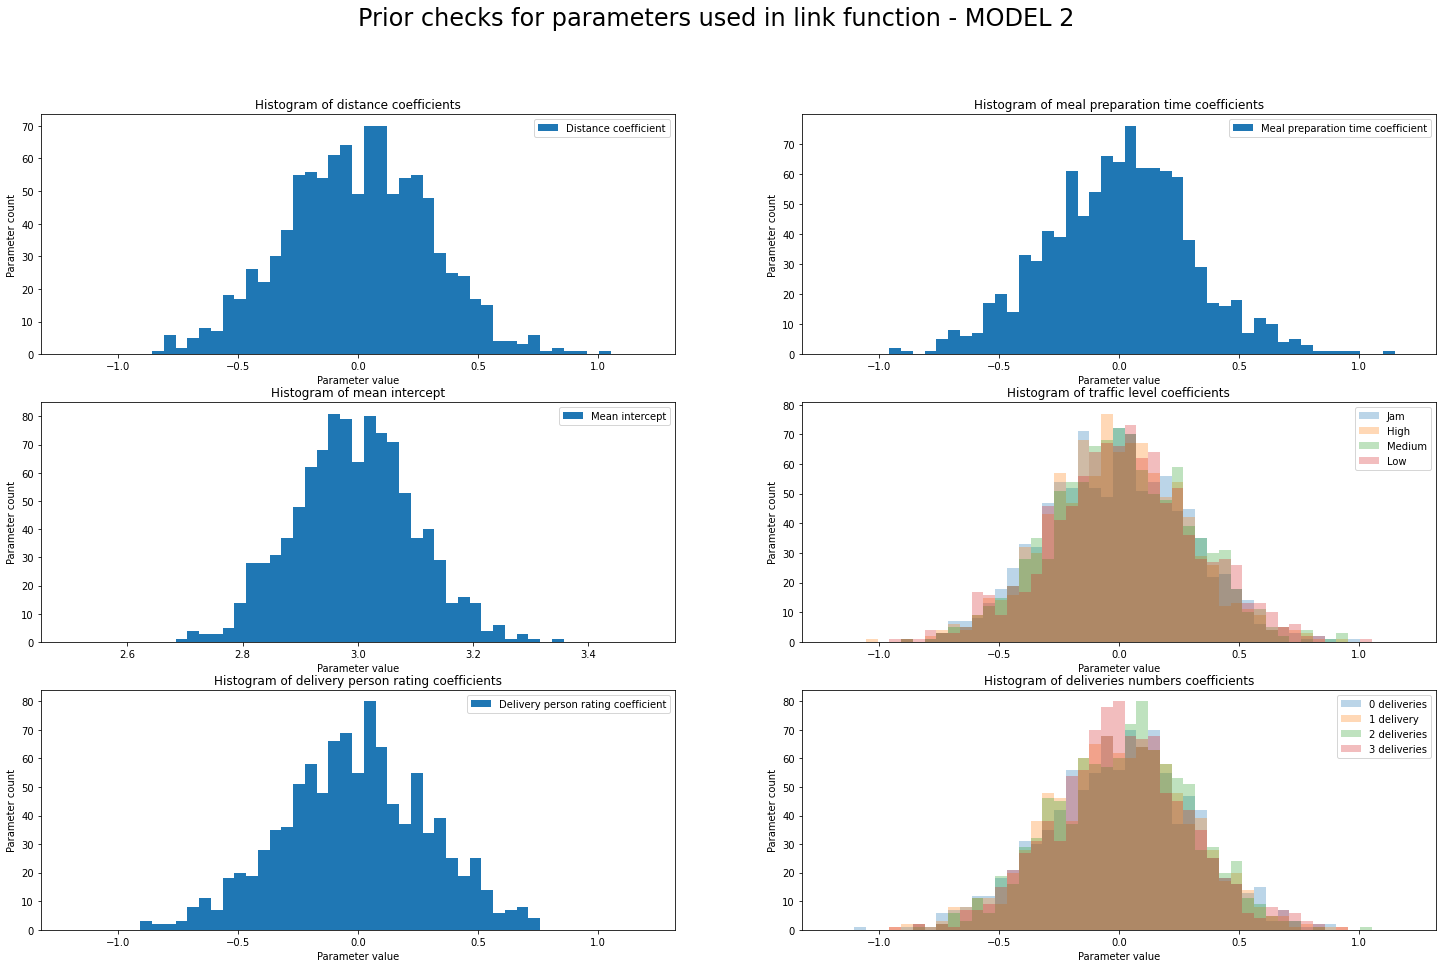

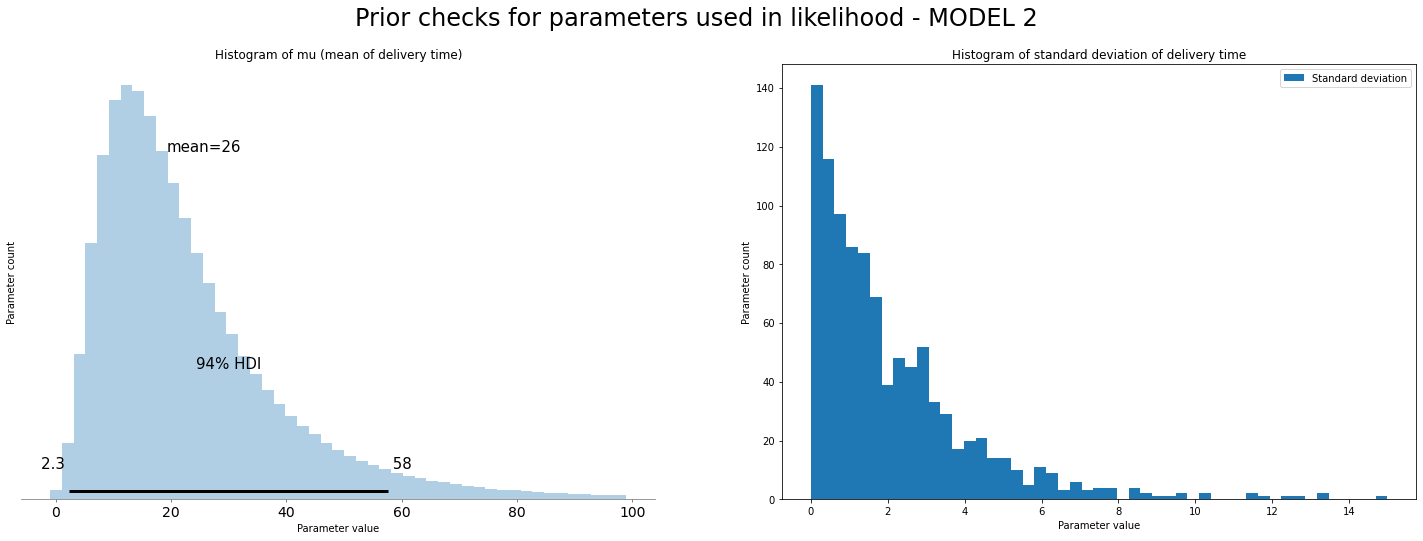

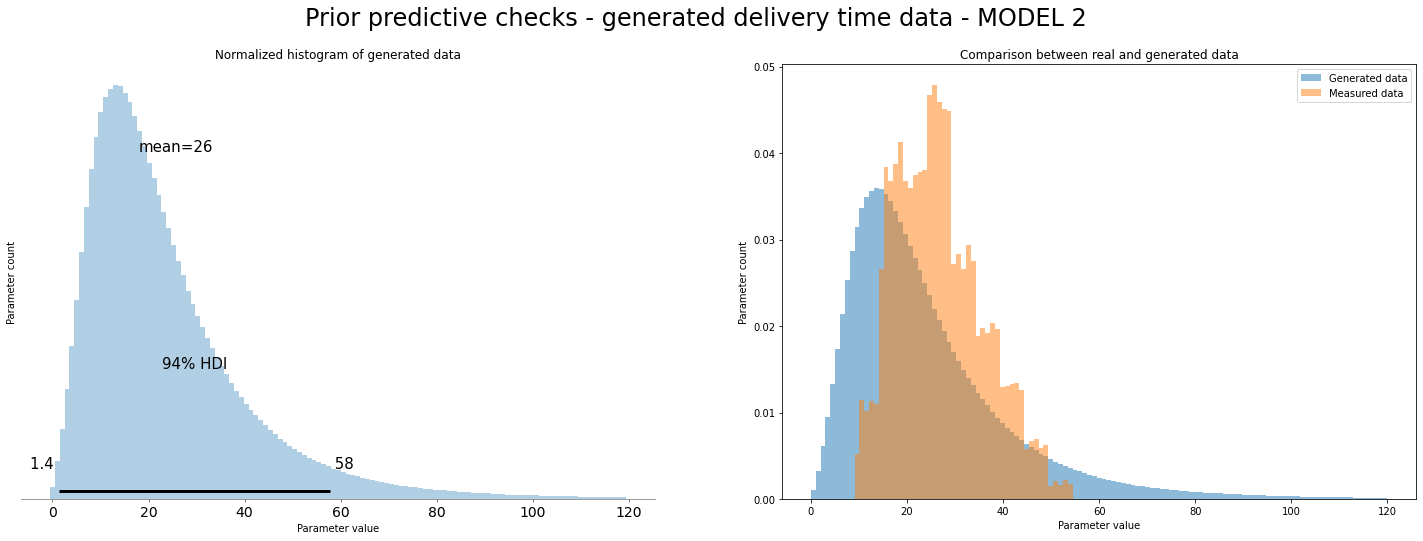

In [8]:
# plot preparation
fig, ax = plt.subplots(3,2, figsize=(25,15))
fig.suptitle("Prior checks for parameters used in link function - MODEL 2", fontsize=24)

# get distance coeff
model2_ppc_distance_coeff = model2_ppc_sim.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model2_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model2_ppc_meal_prep_coeff = model2_ppc_sim.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model2_ppc_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(-1.2,1.2,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model2_ppc_mean = model2_ppc_sim.stan_variable('mean')

# plot mean
ax[1,0].hist(model2_ppc_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model2_ppc_traffic_coeff = model2_ppc_sim.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model2_ppc_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].hist(model2_ppc_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")

# get delivery person rating coeff
model2_ppc_mean = model2_ppc_sim.stan_variable('person_rating_coeff')

# plot elivery person rating coeff
ax[2,0].hist(model2_ppc_mean,label="Delivery person rating coefficient", bins=np.linspace(-1.2,1.2,50))
ax[2,0].legend()
ax[2,0].set_xlabel("Parameter value")
ax[2,0].set_ylabel("Parameter count")
ax[2,0].set_title("Histogram of delivery person rating coefficients")

# get number of deliveries coeffs
model2_ppc_traffic_coeff = model2_ppc_sim.stan_variable('deliveries_number_coeff')

# plot traffic coeff
ax[2,1].hist(model2_ppc_traffic_coeff[:,0],label="0 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,1],label="1 delivery", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,2],label="2 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_ppc_traffic_coeff[:,3],label="3 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].legend()
ax[2,1].set_xlabel("Parameter value")
ax[2,1].set_ylabel("Parameter count")
ax[2,1].set_title("Histogram of deliveries numbers coefficients")
plt.show()

# save plot
fig.savefig('plots/model2/link_params_ppc.png', facecolor='w')

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model2_ppc_mu = model2_ppc_sim.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model2_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(0,100,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model2_ppc_sigma = model2_ppc_sim.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model2_ppc_sigma,label="Standard deviation", bins=np.linspace(0,15,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

# save plot
fig1.savefig('plots/model2/model_params_ppc.png', facecolor='w')

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 2", fontsize=24)

# get measurements
model2_ppc_measurements = model2_ppc_sim.stan_variable('delivery_times').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 120, 120)

az.plot_posterior(model2_ppc_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# plot measurements
ax2[1].hist(model2_ppc_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# save plot
fig2.savefig('plots/model2/generated_data_ppc.png', facecolor='w')


In [2]:
# read fit for model 2
with open('model2_fit.stan') as file:
    print(file.read())

data{
    int N;                          // Number of samples
    vector[N] distance;             // Distances
    vector[N] meal_preparation_time; // Meal preparation times
    vector[N] delivery_times;       // Delivery times
    array[N] int traffic_level;           // Traffic levels
    array[N] real delivery_person_rating;
    array[N] int number_of_deliveries;
}

parameters{
    real distance_coeff;
    real mean;
    vector[4] traffic_level_coeff;
    real meal_prep_coeff;
    real<lower=0> sigma;
    real person_rating_coeff;
    vector[4] deliveries_number_coeff;
}

transformed parameters {
    vector[N] mu;
    for(i in 1:N){
        mu[i] = exp(distance_coeff * distance[i] + traffic_level_coeff[traffic_level[i]] + meal_prep_coeff * meal_preparation_time[i]+person_rating_coeff*delivery_person_rating[i]+deliveries_number_coeff[number_of_deliveries[i]]+mean);
    }

}

model{
    mean ~ normal(3, 0.1);
    person_rating_coeff ~ normal(0,0.3);
    distance_coeff ~ normal(0,0.3)

In [9]:
# delete model 1 from memory (it weighs around 4GBs...)
del model1_sample
del model2_ppc_sim

# load model from previously sampled csvs
model2_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model2/fit')

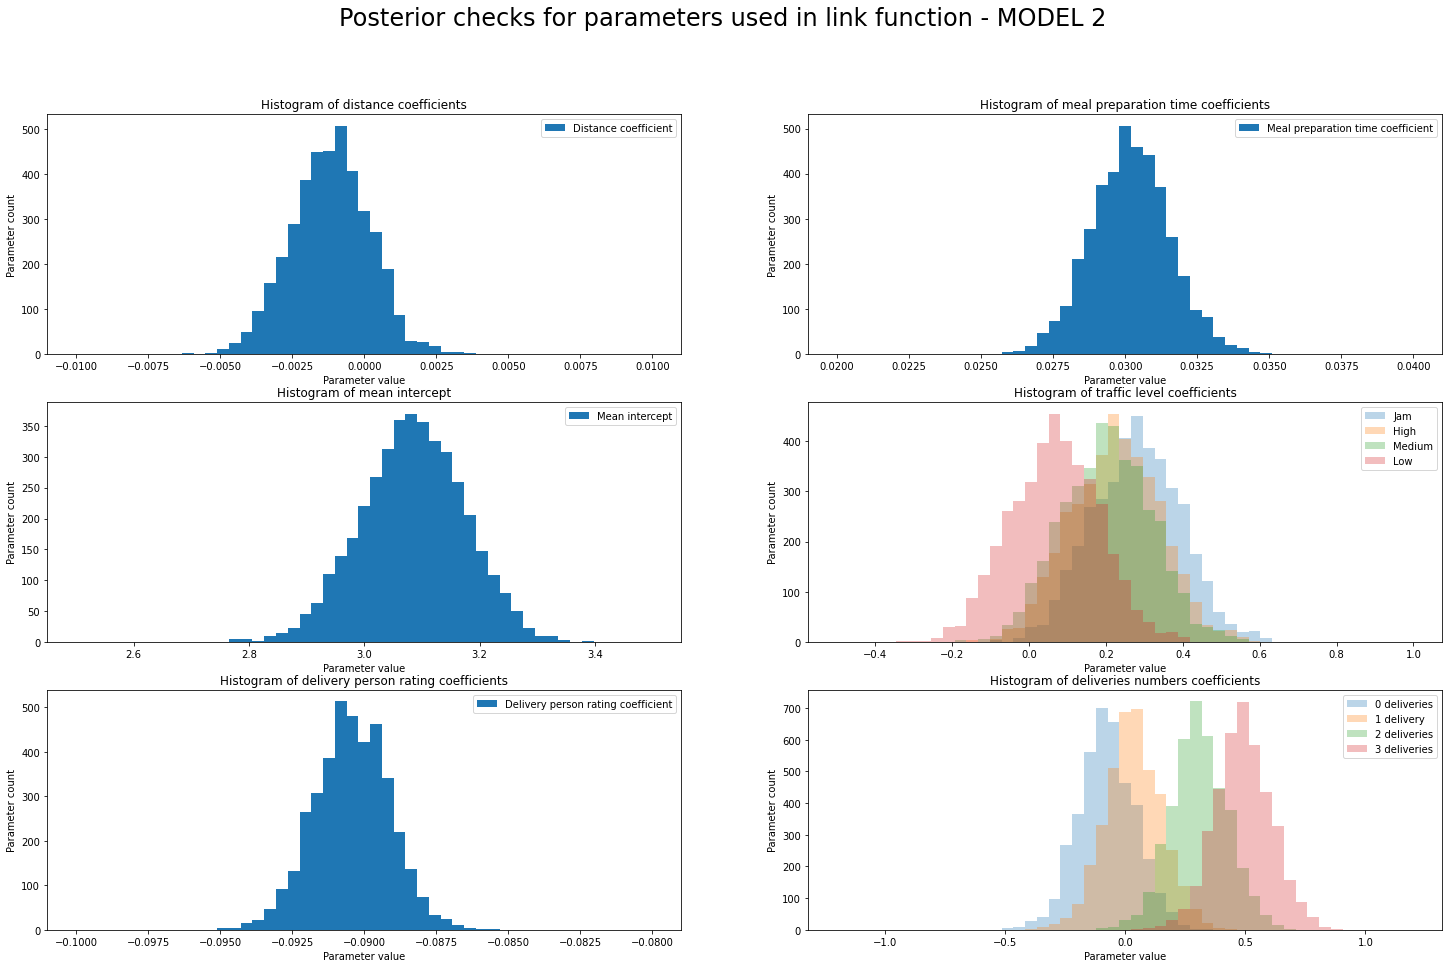

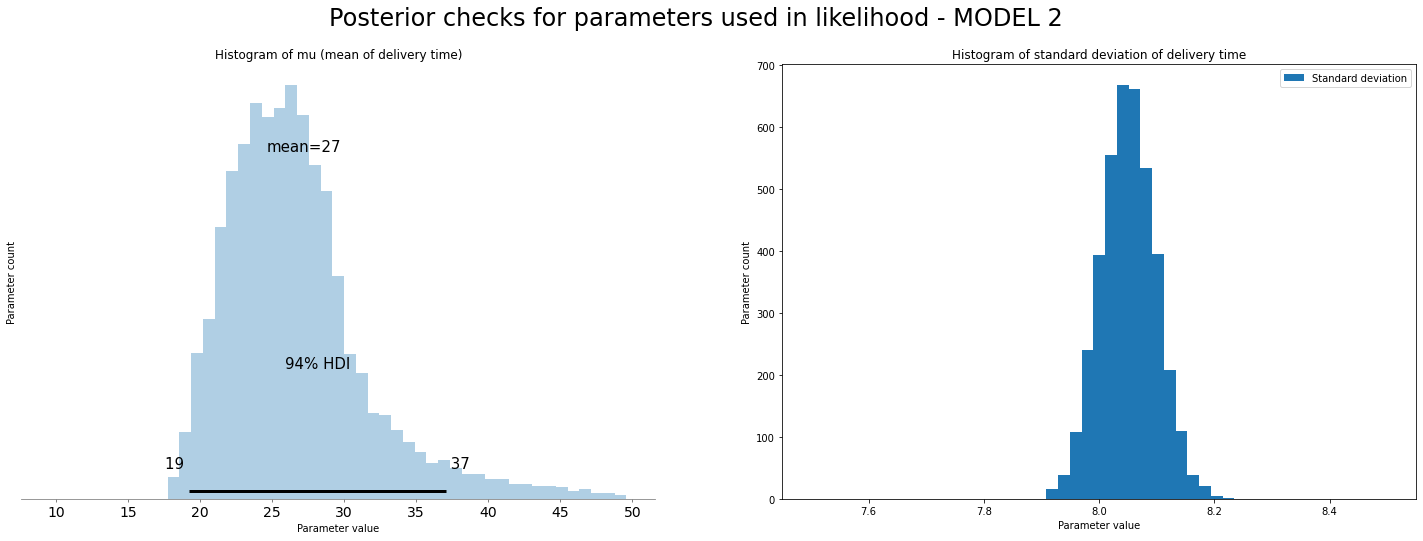

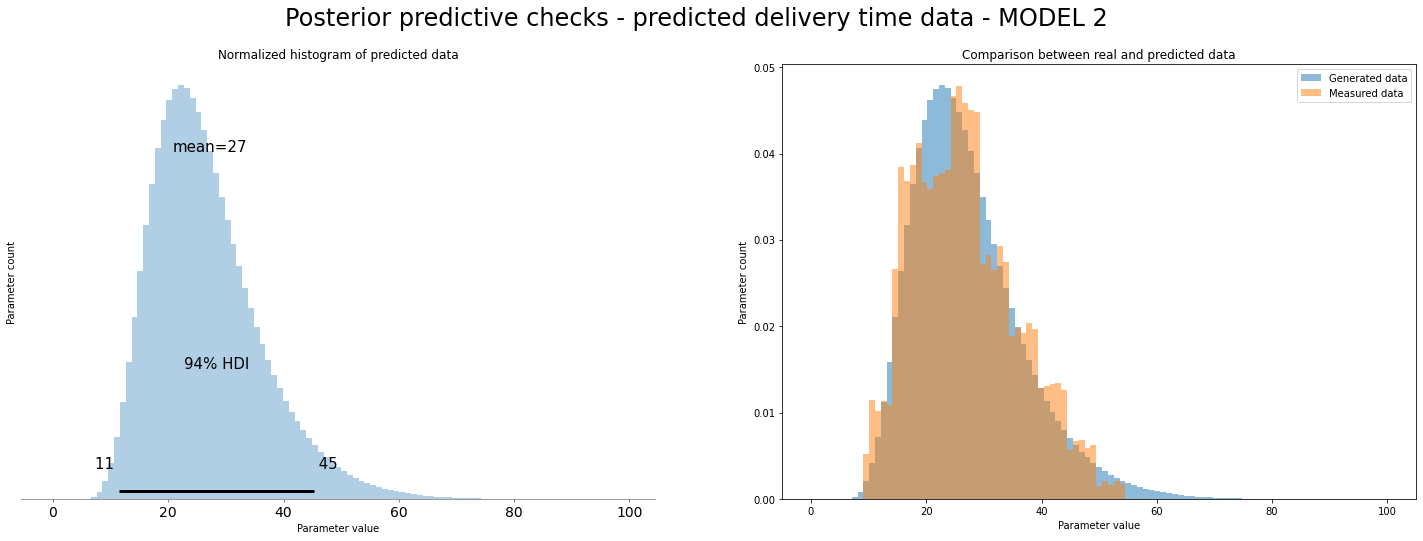

In [10]:
# plot preparation
fig, ax = plt.subplots(3,2, figsize=(25,15))
fig.suptitle("Posterior checks for parameters used in link function - MODEL 2", fontsize=24)

# get distance coeff
model2_fit_distance_coeff = model2_sample.stan_variable('distance_coeff')

# plot distance coeff
ax[0,0].hist(model2_fit_distance_coeff,label="Distance coefficient", bins=np.linspace(-0.01,0.01,50))
ax[0,0].legend()
ax[0,0].set_xlabel("Parameter value")
ax[0,0].set_ylabel("Parameter count")
ax[0,0].set_title("Histogram of distance coefficients")

# get meal_prep_coeff coeff
model2_fit_meal_prep_coeff = model2_sample.stan_variable('meal_prep_coeff')

# plot meal_prep_coeff coeff
ax[0,1].hist(model2_fit_meal_prep_coeff,label="Meal preparation time coefficient", bins=np.linspace(0.02,0.04,50))
ax[0,1].legend()
ax[0,1].set_xlabel("Parameter value")
ax[0,1].set_ylabel("Parameter count")
ax[0,1].set_title("Histogram of meal preparation time coefficients")

# get mean
model2_fit_mean = model2_sample.stan_variable('mean')

# plot mean
ax[1,0].hist(model2_fit_mean,label="Mean intercept", bins=np.linspace(2.5,3.5,50))
ax[1,0].legend()
ax[1,0].set_xlabel("Parameter value")
ax[1,0].set_ylabel("Parameter count")
ax[1,0].set_title("Histogram of mean intercept")

# get traffic level coeff
model2_fit_traffic_coeff = model2_sample.stan_variable('traffic_level_coeff')

# plot traffic coeff
ax[1,1].hist(model2_fit_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-0.5,1,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-0.5,1,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-0.5,1,50))
ax[1,1].hist(model2_fit_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-0.5,1,50))
ax[1,1].legend()
ax[1,1].set_xlabel("Parameter value")
ax[1,1].set_ylabel("Parameter count")
ax[1,1].set_title("Histogram of traffic level coefficients")

# get delivery person rating coeff
model2_fit_person_rating = model2_sample.stan_variable('person_rating_coeff')

# plot elivery person rating coeff
ax[2,0].hist(model2_fit_person_rating,label="Delivery person rating coefficient", bins=np.linspace(-0.1,-0.08,50))
ax[2,0].legend()
ax[2,0].set_xlabel("Parameter value")
ax[2,0].set_ylabel("Parameter count")
ax[2,0].set_title("Histogram of delivery person rating coefficients")

# get number of deliveries coeffs
model2_fit_delivery_number_coeff = model2_sample.stan_variable('deliveries_number_coeff')

# plot traffic coeff
ax[2,1].hist(model2_fit_delivery_number_coeff[:,0],label="0 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,1],label="1 delivery", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,2],label="2 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].hist(model2_fit_delivery_number_coeff[:,3],label="3 deliveries", alpha=0.3, bins=np.linspace(-1.2,1.2,50))
ax[2,1].legend()
ax[2,1].set_xlabel("Parameter value")
ax[2,1].set_ylabel("Parameter count")
ax[2,1].set_title("Histogram of deliveries numbers coefficients")
plt.show()

# save plot
fig.savefig('plots/model2/link_params_fit.png', facecolor='w')

#-------------------------------------PARAMS FOR MODEL-------------------------------------------------
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Posterior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model2_fit_mu = model2_sample.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model2_fit_mu, kind='hist', ax=ax1[0], bins=np.linspace(10,50,50), group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of delivery time)")

# get meal_prep_coeff coeff
model2_fit_sigma = model2_sample.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model2_fit_sigma,label="Standard deviation", bins=np.linspace(7.5,8.5,50))
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of delivery time")
plt.show()

# save plot
fig1.savefig('plots/model2/model_params_fit.png', facecolor='w')

#--------------------------------------PPC MEASUREMENTS------------------------------------------------------

fig2, ax2= plt.subplots(1,2, figsize=(25,8))
fig2.suptitle("Posterior predictive checks - predicted delivery time data - MODEL 2", fontsize=24)

# get measurements
model2_fit_measurements = model2_sample.stan_variable('delivery_time').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 100, 100)

az.plot_posterior(model2_fit_measurements, kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib")
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of predicted data")

# plot measurements
ax2[1].hist(model2_fit_measurements, density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and predicted data")
plt.show()

# save plot
fig2.savefig('plots/model2/sampled_data_fit.png', facecolor='w')


# Comparison

In [8]:
# plots and models are too much for my computer; need to delete all variables from jupyter, load models and then make comparison 

%reset -f

import arviz as az
import matplotlib.pyplot as plt
from cmdstanpy import from_csv

model2_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model2/fit')

model2_az = az.from_cmdstanpy(
    posterior=model2_sample,
)

# delete them, because they use too much RAM
del model2_sample

model1_sample = from_csv('/home/project_repo/data_analytics_project/models_output/model1/fit')

# convert models to arviz format for comparison purposes
model1_az = az.from_cmdstanpy(
    posterior=model1_sample,
)

del model1_sample

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-95433.216525,13.902664,0.000000,0.998148,129.845900,0.00000,False,log
model_1,1,-99845.481867,8.822705,4412.265342,0.001852,122.230901,81.50089,False,log


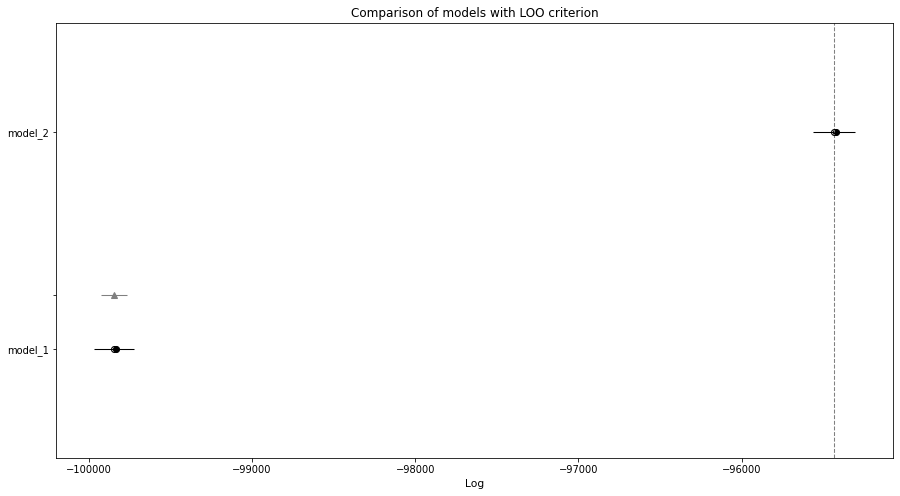

In [11]:
compare_dict = {"model_1": model1_az, "model_2": model2_az}

# loo criterion
loo_diff = az.compare(compare_dict=compare_dict, ic="loo")
display(loo_diff)
fig, ax = plt.subplots(figsize=(15,8))

az.plot_compare(loo_diff, ax=ax)
ax.set_title("Comparison of models with LOO criterion")

fig.savefig('plots/loo_comparison.png', facecolor='w')
# for safety
del loo_diff

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-95433.216943,13.903081,0.000000,0.998148,129.845911,0.000000,False,log
model_1,1,-99845.481799,8.822636,4412.264856,0.001852,122.230899,81.500907,False,log


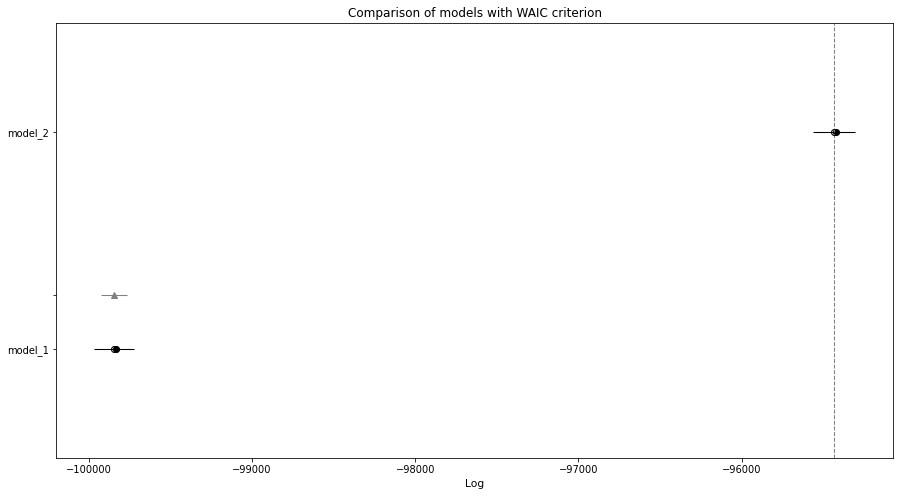

In [12]:
# waic criterion
waic_diff = az.compare(compare_dict=compare_dict, ic="waic")
display(waic_diff)

fig, ax = plt.subplots(figsize=(15,8))

az.plot_compare(waic_diff, ax=ax)
ax.set_title("Comparison of models with WAIC criterion")

fig.savefig('plots/waic_comparison.png', facecolor='w')